
=== NIFTYBEES.NS ===


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_90718/2574107969.py:121: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


Epoch 1/10


/Users/hemank/Documents/github/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0105
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0198
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.7635e-04
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0649e-04
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.2665e-04
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9985e-04
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4104e-04
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2179e-04
Test MAE:  4.3419
Test RMSE: 5.2983
Next-day forecast (for 2025-08-30): $282.51


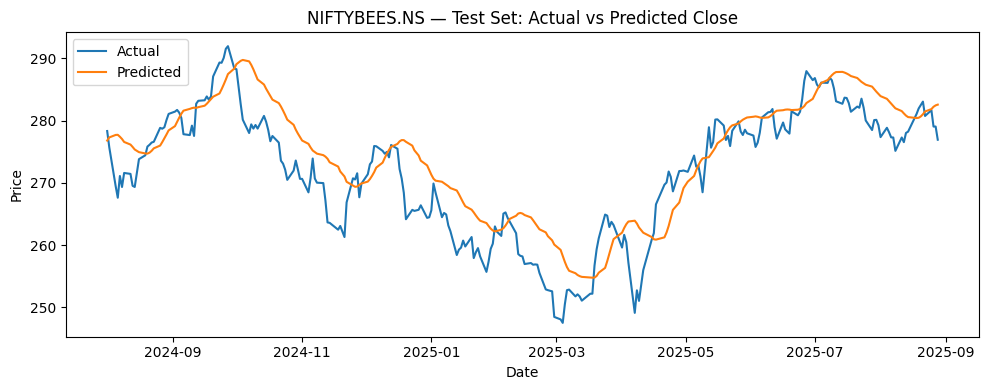


=== Summary ===
NIFTYBEES.NS: MAE=4.3419, RMSE=5.2983, Next(2025-08-30)-> $282.51


In [16]:
"""
Here’s what your (fixed) script does, step by step:

1. Grab and prep the data

* Downloads daily OHLCV data for AAPL from 2020-01-01 to 2024-01-01 with `yfinance`.
* Uses only the **Close** column, reshaped to a 2-D array `(N, 1)`.
* Scales prices to `[0, 1]` with `MinMaxScaler` (so the LSTM trains stably).

2. Turn the series into supervised sequences

* With `look_back = 60`, it builds sliding windows: for each day *t*, **X** contains the previous 60 scaled closes `[t-60 … t-1]`, and **y** is the scaled close at day *t*.
* Shapes after building:

  * `X` → `(N-60, 60, 1)` (samples, timesteps, features)
  * `y` → `(N-60,)`

3. Train / test split (time-ordered)

* Splits the sequences 80/20 into `X_train, y_train` and `X_test, y_test`.
* Because the split is done **after** sequence creation and `shuffle=False` during fit, there’s no temporal shuffling.

4. Define the LSTM model

* First LSTM layer: `return_sequences=True` so it outputs a sequence for each of the 60 steps (this lets you stack another LSTM).
* Second LSTM layer: returns only the final hidden state (summary of the whole 60-day window).
* `Dense(1)`: maps that state to a single number — the **next day’s scaled close**.
* Optimizer/loss: Adam + MSE for regression on a continuous target.

5. Train the model

* `model.fit(..., shuffle=False)` keeps chronological order for batches (safer for time series).

6. Quick (toy) “backtest”

* Picks one random sample from the test set, runs `model.predict(...)`, then **inverse-scales** both prediction and actual to real prices with the same scaler.
* Prints something like: `Predicted: $x.xx, Actual: $y.yy`.

What this model is really learning

* It’s a **sequence-to-one regression**: *Given the last 60 closing prices, predict the next closing price.*
* Inputs: just the close (no volume, no returns, no exogenous features).
* Output: the raw price level (scaled), not the return — simple but can be harder to learn than predicting deltas/returns.

Common gotchas & easy improvements

* **Data leakage:** you currently fit the scaler on *all* data. For a stricter evaluation, fit on **train only**, then transform the test set with that scaler.
* **Evaluation:** selecting one random test point isn’t a real backtest. Better: generate predictions for **every** `X_test` sample, inverse-scale them, and compute MAE/RMSE; plot predicted vs actual.
* **Targets:** consider predicting **returns** (or log returns) and reconstructing prices; often easier and more stationary.
* **Features:** adding technicals (e.g., returns, moving averages, volatility) or multiple assets/market features can help.
* **Walk-forward validation:** retrain periodically on expanding windows to mimic live conditions.
"""
# -*- coding: utf-8 -*-
import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ----------------- Reproducibility -----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ----------------- Config -----------------
TICKERS    = ['NIFTYBEES.NS']  # edit your list
START      = '2020-01-01'
END        = '2025-08-29'
LOOK_BACK  = 60
TRAIN_FRAC = 0.8
EPOCHS     = 10
BATCH_SZ   = 32
SHOW_PLOTS = True     # set False to skip plotting
SAVE_PLOTS = False    # set True to save PNGs

# Pre-compute END+1 calendar day for labeling the forecast
END_DT = pd.to_datetime(END)
NEXT_FORECAST_DATE = END_DT + pd.Timedelta(days=1)  # e.g., 2024-01-02

# ----------------- Helpers -----------------
def build_sequences(scaled_series: np.ndarray, look_back: int):
    """
    scaled_series: shape (N, 1)
    returns X: (N-look_back, look_back, 1), y: (N-look_back,)
    """
    X, y = [], []
    for i in range(look_back, len(scaled_series)):
        X.append(scaled_series[i - look_back:i, 0])
        y.append(scaled_series[i, 0])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

def make_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def mae(a, b):
    return float(np.mean(np.abs(a - b)))

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b) ** 2)))

# ----------------- Main -----------------
results = []

for ticker in TICKERS:
    print(f"\n=== {ticker} ===")
    df = yf.download(ticker, start=START, end=END, progress=False)
    if df.empty or 'Close' not in df.columns:
        print("No data; skipping.")
        continue

    closes = df['Close'].astype(float).values.reshape(-1, 1)
    N = len(closes)
    if N <= LOOK_BACK + 1:
        print(f"Not enough data after LOOK_BACK={LOOK_BACK}; skipping.")
        continue

    # Time-ordered split on raw data (prices)
    split_idx = int(TRAIN_FRAC * N)
    train_raw = closes[:split_idx]
    full_raw  = closes  # keep full series for transform/predictions

    # Fit scaler ONLY on train (avoid leakage)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_raw)
    scaled_all = scaler.transform(full_raw)

    # Build sequences over the FULL scaled series; then split by sequence count
    X_all, y_all = build_sequences(scaled_all, LOOK_BACK)
    M = len(X_all)
    if M == 0:
        print("Sequence build produced no samples; skipping.")
        continue

    seq_split = int(TRAIN_FRAC * M)
    X_train, y_train = X_all[:seq_split], y_all[:seq_split]
    X_test,  y_test  = X_all[seq_split:], y_all[seq_split:]

    if len(X_test) == 0:
        print("Empty test set; reduce TRAIN_FRAC or extend date range. Skipping.")
        continue

    # Dates aligned to each target y
    y_dates = df.index[LOOK_BACK:]          # length M
    test_dates = y_dates[seq_split:]        # aligns with X_test / y_test

    # Build & train model
    model = make_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SZ, shuffle=False, verbose=1)

    # Predict full test set
    y_pred_scaled = model.predict(X_test, verbose=0)         # (n_test, 1)
    y_true_scaled = y_test.reshape(-1, 1)

    # Inverse scale to prices
    y_pred_price = scaler.inverse_transform(y_pred_scaled).reshape(-1)
    y_true_price = scaler.inverse_transform(y_true_scaled).reshape(-1)

    # Metrics
    m_mae  = mae(y_true_price, y_pred_price)
    m_rmse = rmse(y_true_price, y_pred_price)
    print(f"Test MAE:  {m_mae:.4f}")
    print(f"Test RMSE: {m_rmse:.4f}")

    # --------- Next-day (t+1) forecast labeled as END + 1 day ----------
    # Use the LAST look_back window from the FULL series (scaled by train-scaler)
    last_window = scaled_all[-LOOK_BACK:, 0].reshape(1, LOOK_BACK, 1)
    next_scaled = model.predict(last_window, verbose=0)       # (1,1)
    next_price  = scaler.inverse_transform(next_scaled.reshape(-1, 1))[0, 0]

    print(f"Next-day forecast (for {NEXT_FORECAST_DATE.date()}): ${next_price:.2f}")

    # --------- Plot Actual vs Predicted on Test Set ----------
    if SHOW_PLOTS:
        plt.figure(figsize=(10, 4))
        plt.plot(test_dates, y_true_price, label='Actual')
        plt.plot(test_dates, y_pred_price, label='Predicted')
        plt.title(f'{ticker} — Test Set: Actual vs Predicted Close')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()
        if SAVE_PLOTS:
            fname = f'{ticker}_test_pred_vs_actual.png'
            plt.savefig(fname, dpi=150)
        plt.show()
        plt.close()

    # Collect per-ticker outputs (optional)
    out_df = pd.DataFrame({
        'Date': test_dates,
        'Actual': y_true_price,
        'Predicted': y_pred_price
    }).set_index('Date')

    results.append({
        'ticker': ticker,
        'mae': m_mae,
        'rmse': m_rmse,
        'next_date': NEXT_FORECAST_DATE,
        'next_price': next_price,
        'pred_df': out_df
    })

# ----------------- Summary print -----------------
print("\n=== Summary ===")
for r in results:
    print(f"{r['ticker']}: MAE={r['mae']:.4f}, RMSE={r['rmse']:.4f}, Next({r['next_date'].date()})-> ${r['next_price']:.2f}")



In [26]:
# -*- coding: utf-8 -*-
import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pandas.tseries.offsets import BDay

# ----------------- Reproducibility -----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ----------------- Config -----------------
TICKERS      = ['INFY.NS']          # put your list here
START        = '2010-01-01'              # use more years to "train on larger dataset"
END          = '2025-08-28'
TRAIN_FRAC   = 0.85                       # larger train split if you have more data
VAL_FRAC     = 0.12                       # fraction of TRAIN rows (from the tail)
EPOCHS       = 50
BATCH_SZ     = 128
USE_BUSINESS_DAY = True                   # False -> calendar day (END+1), True -> next business day
SHOW_PLOTS   = False
SAVE_PLOTS   = False

# Auto-tuning space for LOOK_BACK (window size the LSTM sees)
TUNE_LOOK_BACKS = (30, 60, 90, 120, 180)

END_DT = pd.to_datetime(END)
FORECAST_DATE = END_DT + (BDay(1) if USE_BUSINESS_DAY else pd.Timedelta(days=1))

# ----------------- Small helpers -----------------
def tofloat(x):
    """Safely convert numpy arrays / scalars to Python float."""
    return float(np.asarray(x).reshape(-1)[0])

def mae(a, b): return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))
def mape(a, b): return float(100 * np.mean(np.abs((a - b) / (a + 1e-9))))
def smape(a, b): return float(100 * np.mean(2 * np.abs(b - a) / (np.abs(a) + np.abs(b) + 1e-9)))

# ----------------- Feature engineering -----------------
def compute_rsi(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    roll_up = up.rolling(period, min_periods=period).mean()
    roll_down = down.rolling(period, min_periods=period).mean()
    rs = roll_up / (roll_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['logret'] = np.log(out['Close']).diff()                      # t return
    out['ma5_gap']  = out['Close'].rolling(5).mean() / out['Close'] - 1
    out['ma10_gap'] = out['Close'].rolling(10).mean() / out['Close'] - 1
    out['ma20_gap'] = out['Close'].rolling(20).mean() / out['Close'] - 1
    out['rsi14']    = compute_rsi(out['Close'], 14) / 100.0          # scale to 0..1
    out['vol20']    = out['logret'].rolling(20).std()                # rolling volatility
    out['logvol']   = np.log1p(out['Volume'])
    out['volz20']   = (out['logvol'] - out['logvol'].rolling(20).mean()) / (out['logvol'].rolling(20).std() + 1e-9)
    # Next-day target: log return at t+1
    out['y'] = out['logret'].shift(-1)
    return out

# ----------------- Sequence builder -----------------
def build_sequences(feat_mat: np.ndarray,
                    y_vec: np.ndarray,
                    closes_vec: np.ndarray,
                    dates_idx: pd.DatetimeIndex,
                    look_back: int):
    """
    Build samples ending at time t with target = return at t+1.
    For a sample ending at index i-1 (sequence uses rows [i-look_back, i)):
      y uses y_vec[i-1] (equals logret at i)
      prev_close = closes_vec[i-1] (price at t)
      target_date = dates_idx[i] (date of t+1)
    """
    X, y, prev_close, target_dates = [], [], [], []
    N = len(feat_mat)
    for i in range(look_back, N):
        X.append(feat_mat[i - look_back:i, :])
        y.append(y_vec[i - 1])
        prev_close.append(closes_vec[i - 1])
        target_dates.append(dates_idx[i])
    return np.array(X), np.array(y), np.array(prev_close), pd.to_datetime(target_dates)

# ----------------- Model -----------------
def make_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ----------------- Tuner -----------------
def tune_look_back(ticker, look_backs=TUNE_LOOK_BACKS):
    """
    Try multiple LOOK_BACK values and pick the best by lowest validation loss
    (tie-broken by lowest test RMSE on prices).
    Returns: dict with keys {lb, val_loss, test_rmse}
    """
    best = {"lb": None, "val_loss": np.inf, "test_rmse": np.inf}

    # Load data
    df = yf.download(ticker, start=START, end=END, progress=False, auto_adjust=True)
    if df.empty or 'Close' not in df.columns:
        print(f"[{ticker}] No data. Skipping tune.")
        return best

    f = add_features(df)
    cols = ['logret','ma5_gap','ma10_gap','ma20_gap','rsi14','vol20','volz20','y','Close']
    f = f[cols].dropna().copy()
    if len(f) < 200:
        print(f"[{ticker}] Too few rows after features: {len(f)}. Skipping tune.")
        return best

    n_rows = len(f)
    row_split = int(TRAIN_FRAC * n_rows)
    val_rows  = int(VAL_FRAC * row_split)
    train_rows = row_split - val_rows

    feat_cols = ['logret','ma5_gap','ma10_gap','ma20_gap','rsi14','vol20','volz20']
    feat_raw  = f[feat_cols].values
    y_raw     = f['y'].values
    closes    = f['Close'].values.astype(float)
    dates     = f.index

    # Fit scaler on TRAIN+VAL (no test leakage)
    scalerX = StandardScaler().fit(feat_raw[:row_split])
    feat_scaled_all = scalerX.transform(feat_raw)

    for LB in look_backs:
        if train_rows <= LB + 5:
            print(f"[{ticker}] LB={LB:>3} -> train too small. Skipping.")
            continue

        X_all, y_all, prev_close_all, _ = build_sequences(
            feat_scaled_all, y_raw, closes, dates, LB
        )

        # Sequence splits so windows don't cross folds
        seq_split = max(1, row_split - LB)         # start of TEST sequences
        seq_val_split = max(1, train_rows - LB)    # start of VAL sequences

        if seq_split <= 1 or seq_val_split <= 1 or len(X_all[seq_split:]) == 0:
            print(f"[{ticker}] LB={LB:>3} -> empty test/val. Skipping.")
            continue

        X_train,  y_train  = X_all[:seq_val_split], y_all[:seq_val_split]
        X_val,    y_val    = X_all[seq_val_split:seq_split], y_all[seq_val_split:seq_split]
        X_test,   y_test   = X_all[seq_split:], y_all[seq_split:]
        prev_test = prev_close_all[seq_split:]

        model = make_model((X_train.shape[1], X_train.shape[2]))
        cb = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        ]
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val) if len(X_val) > 0 else None,
            epochs=EPOCHS, batch_size=BATCH_SZ, shuffle=False, verbose=0, callbacks=cb
        )

        # Lowest val_loss seen (fallback to loss if val missing)
        vloss_hist = hist.history.get('val_loss', None)
        val_loss = np.min(vloss_hist) if vloss_hist else np.min(hist.history['loss'])

        # Test RMSE on prices
        y_pred_ret = model.predict(X_test, verbose=0).reshape(-1)
        y_true_ret = y_test.reshape(-1)
        y_pred_price = prev_test * np.exp(y_pred_ret)
        y_true_price = prev_test * np.exp(y_true_ret)
        test_rmse = rmse(y_true_price, y_pred_price)

        print(f"[{ticker}] LB={LB:>3}  val_loss={val_loss:.6f}  test_RMSE={test_rmse:.4f}  (n_test={len(y_true_price)})")

        better = (val_loss < best["val_loss"]) or \
                 (np.isclose(val_loss, best["val_loss"]) and test_rmse < best["test_rmse"])
        if better:
            best.update({"lb": LB, "val_loss": float(val_loss), "test_rmse": float(test_rmse)})

    return best

# ----------------- Train/Eval/Forecast with chosen LOOK_BACK -----------------
def train_and_forecast(ticker, look_back):
    print(f"\n=== {ticker} | LOOK_BACK={look_back} ===")
    df = yf.download(ticker, start=START, end=END, progress=False, auto_adjust=True)
    if df.empty or 'Close' not in df.columns:
        print("No data; skipping.")
        return None

    f = add_features(df)
    needed = ['logret','ma5_gap','ma10_gap','ma20_gap','rsi14','vol20','volz20','y','Close']
    f = f[needed].dropna().copy()
    if len(f) <= look_back + 10:
        print("Not enough rows after features; skipping.")
        return None

    n_rows = len(f)
    row_split = int(TRAIN_FRAC * n_rows)
    val_rows  = int(VAL_FRAC * row_split)
    train_rows = row_split - val_rows
    if train_rows <= look_back:
        print("Training span too small given LOOK_BACK; adjust splits.")
        return None

    feat_cols = ['logret','ma5_gap','ma10_gap','ma20_gap','rsi14','vol20','volz20']
    feat_raw  = f[feat_cols].values
    y_raw     = f['y'].values
    closes    = f['Close'].values.astype(float)
    dates     = f.index

    scalerX = StandardScaler().fit(feat_raw[:row_split])     # train+val only
    feat_scaled_all = scalerX.transform(feat_raw)

    X_all, y_all, prev_close_all, target_dates_all = build_sequences(
        feat_scaled_all, y_raw, closes, dates, look_back
    )

    seq_split = max(1, row_split - look_back)
    seq_val_split = max(1, train_rows - look_back)

    X_train,  y_train  = X_all[:seq_val_split], y_all[:seq_val_split]
    X_val,    y_val    = X_all[seq_val_split:seq_split], y_all[seq_val_split:seq_split]
    X_test,   y_test   = X_all[seq_split:], y_all[seq_split:]
    prev_test = prev_close_all[seq_split:]
    dates_test = target_dates_all[seq_split:]

    if len(X_test) == 0:
        print("Empty test set; adjust dates/splits.")
        return None

    # Build & train
    model = make_model((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if len(X_val) > 0 else None,
        epochs=EPOCHS, batch_size=BATCH_SZ, shuffle=False, verbose=1,
        callbacks=callbacks
    )

    # Predict returns on test, convert to prices
    y_pred_ret = model.predict(X_test, verbose=0).reshape(-1)
    y_true_ret = y_test.reshape(-1)
    y_pred_price = prev_test * np.exp(y_pred_ret)
    y_true_price = prev_test * np.exp(y_true_ret)

    # Metrics
    metrics = {
        "mae": mae(y_true_price, y_pred_price),
        "rmse": rmse(y_true_price, y_pred_price),
        "mape": mape(y_true_price, y_pred_price),
        "smape": smape(y_true_price, y_pred_price),
        "dir_acc": float(np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))),
        "n_test": int(len(y_true_price))
    }
    print(f"Test MAE={metrics['mae']:.4f}  RMSE={metrics['rmse']:.4f}  "
          f"MAPE={metrics['mape']:.2f}%  sMAPE={metrics['smape']:.2f}%  "
          f"DirAcc={metrics['dir_acc']*100:.2f}%  n_test={metrics['n_test']}")

    # Next-day (END+1) forecast
    last_feat_rows = feat_scaled_all[-look_back:, :]
    last_close     = tofloat(closes[-1])
    next_ret       = tofloat(model.predict(last_feat_rows.reshape(1, look_back, len(feat_cols)), verbose=0))
    next_price     = tofloat(last_close * np.exp(next_ret))
    print(f"Next-day forecast (for {FORECAST_DATE.date()}): {next_price:.2f}")

    # Plot if enabled
    if SHOW_PLOTS:
        plt.figure(figsize=(10, 4))
        plt.plot(dates_test, y_true_price, label='Actual Close (Test)')
        plt.plot(dates_test, y_pred_price, label='Predicted Close')
        plt.title(f'{ticker} — Test Set: Actual vs Predicted Close (LB={look_back})')
        plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.tight_layout()
        if SAVE_PLOTS: plt.savefig(f'{ticker}_pred_vs_actual_LB{look_back}.png', dpi=150)
        plt.show(); plt.close()

    return {
        "ticker": ticker,
        "look_back": int(look_back),
        "metrics": metrics,
        "forecast_date": FORECAST_DATE,
        "next_price": next_price
    }

# ----------------- Main -----------------
all_results = []
for tk in TICKERS:
    print(f"\n>>> Tuning LOOK_BACK for {tk} over {TUNE_LOOK_BACKS} ...")
    best = tune_look_back(tk, TUNE_LOOK_BACKS)
    chosen_lb = best["lb"] if best["lb"] is not None else 60
    print(f"Chosen LOOK_BACK for {tk}: {chosen_lb} "
          f"(val_loss={best['val_loss']:.6f} test_RMSE={best['test_rmse']:.4f})" if best["lb"] else
          f"No valid LB found; falling back to {chosen_lb}")

    res = train_and_forecast(tk, chosen_lb)
    if res: all_results.append(res)

print("\n=== Summary ===")
for r in all_results:
    m = r["metrics"]
    print(f"{r['ticker']} | LB={r['look_back']} | "
          f"MAE={m['mae']:.4f} RMSE={m['rmse']:.4f} MAPE={m['mape']:.2f}% sMAPE={m['smape']:.2f}% "
          f"DirAcc={m['dir_acc']*100:.2f}% n_test={m['n_test']} | "
          f"Next({r['forecast_date'].date()}) -> {r['next_price']:.2f}")



>>> Tuning LOOK_BACK for INFY.NS over (30, 60, 90, 120, 180) ...
[INFY.NS] LB= 30  val_loss=0.000291  test_RMSE=23.6727  (n_test=577)
[INFY.NS] LB= 60  val_loss=0.000291  test_RMSE=23.3814  (n_test=577)
[INFY.NS] LB= 90  val_loss=0.000312  test_RMSE=23.5633  (n_test=577)
[INFY.NS] LB=120  val_loss=0.000327  test_RMSE=24.3285  (n_test=577)
[INFY.NS] LB=180  val_loss=0.000304  test_RMSE=23.6719  (n_test=577)
Chosen LOOK_BACK for INFY.NS: 60 (val_loss=0.000291 test_RMSE=23.3814)

=== INFY.NS | LOOK_BACK=60 ===
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0069 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0027 - val_loss: 4.6738e-04 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0015 - val_loss: 7.4542e-04 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0014 - val_loss: 4.0601e-04 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 

Absolutely — here’s what your script does, step by step, and why each part exists. I’ll keep the order exactly as the code flows.

---

# High-level overview

You’re building a **next-day return** predictor for a single stock using:
1. TA-Lib + pandas to create technical features (shifted to avoid leakage)
	•	They use TA-Lib (a technical analysis library) and pandas to compute indicators like SMA, EMA, RSI, Bollinger Bands, MACD, etc.
	•	Features are shifted so that the model doesn’t “peek into the future” (data leakage).
Example: Instead of using today’s RSI to predict today’s return, you shift RSI(𝑡−1) to predict return(𝑡).

⸻

2. Volatility-scaled target to stabilize variance
	•	Instead of predicting raw returns, they divide returns by recent volatility (like ATR or rolling std).
	•	This makes the target more stable, because raw returns are noisy and heteroscedastic (variance changes over time).
	•	It helps the model focus on risk-adjusted returns rather than absolute size.

⸻

3. Walk-forward (time-series) cross-validation with a small purge gap
	•	Standard k-fold CV doesn’t work in time-series (leaks future info).
	•	So they use walk-forward CV:
	•	Train on 2010–2015, test on 2016
	•	Train on 2010–2016, test on 2017
	•	… and so on.
	•	A purge gap is added so that overlapping data near the split (which can leak info due to autocorrelation) is excluded.

⸻

4. An ensemble of base models (ElasticNet, RandomForest, optional XGBoost/LightGBM)
	•	They don’t rely on a single model.
	•	Base models:
	•	ElasticNet → good for linear trends + feature selection.
	•	RandomForest → good for nonlinear patterns.
	•	XGBoost/LightGBM → gradient boosting, powerful on tabular data.

⸻

5. Stacking (a Ridge meta-model learns how to mix base models)
	•	After training base models, their predictions (meta-features) are combined.
	•	A Ridge Regression (meta-model) learns the best weights for each base model.
	•	Example: maybe RF is best in volatile markets, ElasticNet in trending ones.
	•	This stacking often outperforms single models.

⸻

6. A quick OOF backtest (long-only with costs) for sanity
	•	OOF = Out-Of-Fold predictions (predictions on unseen test folds during CV).
	•	They run a simple trading backtest:
	•	Long if prediction > 0 (model expects positive return).
	•	Flat otherwise.
	•	Deduct transaction costs.
	•	This is just a sanity check to see if the model has any predictive power.

The script prints:

* Each base model’s OOF RMSE,
* The stacker’s OOF RMSE,
* A **single next-day forecast** (return and implied price),
* Simple OOF backtest stats (total return, hit rate, Sharpe).

---

# Detailed walkthrough

## 1) CONFIG

```python
TICKER="INFY.NS", START_DATE, END_DATE, SPLITS, GAP_DAYS, USE_VOL_SCALE, FEE_RT, THRESH_LONG
```

* Controls symbol & date range (**yfinance** daily bars).
* `SPLITS`: number of time-series CV folds.
* `GAP_DAYS`: drops the first `gap` rows of each validation fold to **purge overlap** (reduces label leakage from overlapping windows).
* `USE_VOL_SCALE=True`: model `y_scaled = next_return / prev_vol20`. This stabilizes the target; later you rescale the prediction by the last known `vol20`.
* `FEE_RT`: approximate round-turn cost used in the backtest (adjust to your broker).
* `THRESH_LONG`: only take a trade if predicted next-day return exceeds this (filters noise).

## 2) IMPORTS

* `pandas`, `numpy`, `yfinance` for data.
* `sklearn` for models, scaling, splitting, metrics.
* Optional: `xgboost`, `lightgbm` if installed.

## 3) HELPERS

### `_as_float1d(x)`

TA-Lib needs **1-D contiguous float64 arrays**. This coerces Series/DataFrame to `np.float64` 1-D and contiguous. Prevents the “wrong dimensions”/dtype errors you hit earlier.

### `_select_single_ticker_ohlcv(df, ticker)`

yfinance sometimes returns **MultiIndex columns** (e.g., multiple tickers). This picks the one ticker you want regardless of whether the layout is `(ticker -> OHLCV)` or `(OHLCV -> ticker)`.
It also:

* Falls back to `Adj Close` if `Close` isn’t present,
* Ensures you end with exactly `Open, High, Low, Close, Volume`,
* Coerces to numeric and drops bad rows,
* Returns a clean, single-ticker OHLCV DataFrame.

## 4) DOWNLOAD + SHAPE

```python
raw = yf.download(...)
df  = _select_single_ticker_ohlcv(raw, TICKER)
```

* Pulls daily OHLCV.
* Ensures you have at least \~600 rows (so CV has enough data).
* Creates shorthands: `cl, hi, lo, vo` and daily returns `ret = cl.pct_change()`.

## 5) TA-LIB SETUP

```python
try: import talib as ta; HAS_TA=True
except: HAS_TA=False
```

* If TA-Lib isn’t installed, the script uses **pandas fallbacks** for indicators.

## 6) INDICATOR WRAPPERS

* `rsi`, `macd`, `stoch`, `bbands`, `adx`, `atr`, `mfi`, `cci`, `willr`, `obv`
* Each function:

  * If `HAS_TA`, calls the TA-Lib function with `_as_float1d(...)`.
  * Else computes a close approximation in pandas.
* All feature outputs are aligned to the input index.

**Key point:** later you call `.shift(1)` on almost all features to **avoid look-ahead** (use only information known at the close of day *t* to predict day *t+1*).

## 7) FEATURES (no leakage)

```python
rsi14 = rsi(cl, 14).shift(1)
macd_line, macd_sig, macd_hist = macd(cl); then shift(1)
stoch_k, stoch_d = stoch(...); shift(1)
bb_up, bb_mid, bb_low = bbands(cl); shift(1)
bb_width = (bb_up - bb_low)/bb_mid  # width; already shifted via inputs
...
obv_val = obv(cl, vo).pct_change().shift(1)
```

* You compute a diverse set: momentum (RSI/MACD/Stoch), volatility (ATR, BB width), trend/strength (ADX, CCI, Williams %R), volume (MFI, OBV ROC), lag/rolling stats (recent returns, mean & std), and weekday dummies.
* Everything is `shift(1)` or derived from shifted values, so **all features are known at prediction time**.

`X` is then assembled from these features and infinities are replaced with NaN (to be dropped later).

## 8) TARGET (next-day return) + volatility scaling

```python
y_next = ret.shift(-1)           # tomorrow’s return
vol20  = ret.rolling(20).std()   # rolling daily vol
y      = y_next / vol20.shift(1) # if USE_VOL_SCALE
```

* **Raw target** is next day’s simple return.
* If `USE_VOL_SCALE`, you **stabilize** the target by dividing by the **last known** 20-day volatility (shifted by 1).
  This reduces heteroscedasticity (wide swings in variance), often improving fit.
* Finally, `data = concat(X, y, y_next).dropna()` ensures rows have complete features & target.

## 9) TIME-SERIES CV + BASE MODELS

### `ts_purged_splits(...)`

* Wraps `TimeSeriesSplit(n_splits=SPLITS)` but **drops the first `gap` rows of each test fold** to reduce information bleed from overlapping windows (a form of leakage).

### Base models

```python
("enet", ElasticNet(...)), ("rf", RandomForestRegressor(...)), ("xgb", ...?), ("lgbm", ...?)
```

* **ElasticNet** (linear, L1+L2): good for mostly linear relationships and mild feature selection.
* **RandomForest**: nonlinear, robust to outliers; captures interactions.
* **XGB/LGBM** (if installed): gradient boosted trees; strong tabular baselines.

**OOF predictions:**

* For each fold:

  * Fit models on the training slice.
  * Predict the validation slice.
  * Store predictions into `oof_preds[name][te]`.
  * Store ground truth into `oof_truth[te]`.

**Why OOF?** Out-of-fold predictions simulate “unseen” data and are needed to **train the stacker without leakage**.

### OOF RMSE printout

```python
rmse = RMSE(oof_truth[m], oof_preds[name][m])
```

* Your sklearn version didn’t support `squared=False`, so you use a small `RMSE()` wrapper.
* This gives **walk-forward** error per base model on the (scaled) target `y`.

## 10) STACKED META-MODEL

```python
Z = DataFrame({name: oof_preds[name]}, index=X.index)
mask_all_series = Series(~np.isnan(oof_truth), index=X.index)
mask = Z.notna().all(axis=1) & mask_all_series
meta = Ridge(alpha=1.0)
meta.fit(Z.loc[mask].values, oof_truth[mask])
```

* `Z` collects the base models’ OOF predictions as columns; **indexed by X.index** to align perfectly.
* `mask` selects rows where **all** base OOF preds exist **and** the truth exists.
* `Ridge` is trained on these OOF predictions to learn **the optimal blend** (stacking).
* You print the stacker’s OOF RMSE — this is usually **lower** than individual base models.

*(You previously fixed an “unalignable boolean Series” error by forcing all these objects to share the same index, then assigning by `valid_idx`.)*

## 11) FIT ALL DATA & PRODUCE NEXT-DAY FORECAST

* Refit all base models on **all available data**:

  * ElasticNet uses **scaled** features (`StandardScaler`) because linear models are sensitive to scale.
  * Tree/boosted models use raw features (they’re scale-invariant).
* Build `base_next` by predicting the **last row** with each base model.
* Feed `base_next` into the `meta` stacker to get `y_hat_scaled`.
* If `USE_VOL_SCALE`, **rescale** the stacker’s output by the **last known** `vol20` to get a raw return forecast `y_hat`.
* Convert to predicted price:

  ```python
  pred_next_close = last_close * (1 + y_hat)
  ```
* Print the last close, predicted return, predicted next close.

**Interpretation:** `y_hat` is the model’s expected simple return for the *next* daily bar. It’s often a small number (bps). It’s not a certainty — treat it like a noisy signal.

## 12) QUICK OOF BACKTEST (long-only)

```python
oof_meta = Series(NaN, index=X.index)
valid_idx = mask[mask].index
oof_meta.loc[valid_idx] = meta.predict(Z.loc[valid_idx].values)
```

* Recomputes the **stacker predictions** using only OOF rows (never in-sample for that fold).

**Unscale (if needed):**

```python
pred_unscaled = oof_meta * vol20   # if USE_VOL_SCALE
```

**Signals & PnL:**

* **Entry rule:** go long if predicted next-day return > `THRESH_LONG`.
* **Turnover & fees:** pay a half round-turn each time you switch position (simple approximation).
* **PnL:** yesterday’s signal \* today’s realized next-day return − fees.
* **Equity:** cumulative product of (1 + pnl).
* Prints **Total Return (after fees)**, **Directional Accuracy**, and **daily Sharpe**.

> This is a **sanity check**, not a production backtest:
>
> * It’s **OOF only**, which is good (no in-sample cheating), but it’s very simple (no position sizing, no risk controls).
> * If this can’t beat costs out-of-fold, the signal is likely too weak to trade as-is.

---

# What the printed numbers mean

* **“Walk-forward CV (OOF) … RMSE”**
  Error of each base model on the *scaled* target (if enabled). Lower is better.

* **“stack RMSE (on OOF)”**
  Error of the **blended** prediction. Should be ≤ best base model RMSE if stacking helps.

* **“Next-day Forecast”**
  The single forecast for the next daily bar:
  last close, predicted next-day **return**, and implied **next close**.

* **Backtest block**

  * **Total return (after fees)** on OOF predictions applying a simple long-only rule.
  * **Directional accuracy:** fraction of times the sign of predicted return matched the realized return.
  * **Sharpe (daily):** annualized (√252) mean/std of daily pnl.

---

# Knobs you can tune

* **Features:** add/remove indicators; try longer/shorter windows; add regime flags (e.g., SMA cross).
* **Target:** stick with `USE_VOL_SCALE=True`. You can also try Huber loss in boosters (robust to outliers).
* **Models:** enable XGB/LGBM if installed; increase estimators mildly; or run Optuna tuning.
* **CV:** increase `SPLITS` (more folds) and adjust `GAP_DAYS` (≥ 1 is good for dailies).
* **Threshold & fees:** calibrate `THRESH_LONG` to maximize OOF Sharpe net of **your** costs.

---

# Common pitfalls (and how this script avoids them)

* **Data leakage:** all features are `.shift(1)`; target uses `.shift(-1)`; CV is time-ordered with a purge gap.
* **TA-Lib crashes:** `_as_float1d` forces the exact dtype/shape it expects.
* **yfinance MultiIndex:** `_select_single_ticker_ohlcv` normalizes layout and columns.
* **Sklearn version differences:** `RMSE()` helper avoids reliance on `squared=False`.

---

If you want, I can:

* Add an **intraday** version (India 9:15–15:30) with VWAP/OR range features and a 15:25 exit,
* Plug in **Optuna** for automated hyper-parameter tuning,
* Or export the **OOF predictions** and **feature importances** so you can inspect where the model is winning/losing.


In [16]:
# =========================================
# CONFIG
# =========================================
TICKER        = "INFY.NS"
START_DATE    = "2015-01-01"
END_DATE      = None

SPLITS        = 6
GAP_DAYS      = 1

USE_VOL_SCALE    = True       # train target as y/vol and rescale back
THRESH_IN_SIGMA  = True       # interpret thresholds in sigma units (y/σ) using oof_meta
ALLOW_SHORTS     = True       # allow short positions if signal < -threshold

# Backtest costs and knobs
FEE_RT        = 0.0006        # round-turn fee+slippage
INIT_CAPITAL  = 1.0           # normalized

# Position sizing mode
USE_POSITION_SIZING = True    # if False => fixed 1x positions gated by thresholds
SIZE_K_GRID         = [0.5, 0.75, 1.0, 1.25, 1.5]  # tanh gain sweep (only if USE_POSITION_SIZING)

# Threshold grid (we'll auto-pick best)
# If THRESH_IN_SIGMA=True, these are in sigma units (on oof_meta). Otherwise in raw returns (on pred_unscaled).
THRESH_GRID   = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # sigma units (≈ standard deviations)
THRESH_GRID_RAW = [0.0, 0.0003, 0.0005, 0.0007, 0.0010, 0.0015]          # raw return units (fallback if THRESH_IN_SIGMA=False)

# =========================================
# IMPORTS
# =========================================
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor

# Optional boosters
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# =========================================
# HELPERS
# =========================================
def RMSE(y_true, y_pred):
    # sklearn<0.22 compatibility (no squared=False)
    from sklearn.metrics import mean_squared_error
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def max_drawdown(equity: pd.Series):
    peak = equity.cummax()
    dd = (equity - peak) / peak
    return float(dd.min()) if len(dd) else 0.0

def _as_float1d(x):
    if isinstance(x, pd.DataFrame):
        x = x.squeeze()
    x = pd.to_numeric(pd.Series(x), errors="coerce")
    a = np.asarray(x, dtype=np.float64).reshape(-1)
    return np.ascontiguousarray(a, dtype=np.float64)

def _select_single_ticker_ohlcv(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        lev0 = df.columns.get_level_values(0).unique()
        lev1 = df.columns.get_level_values(1).unique()
        if ticker in lev0:
            sub = df[ticker].copy()
        elif ticker in lev1:
            sub = df.xs(ticker, axis=1, level=1).copy()
        else:
            raise ValueError(f"TICKER '{ticker}' not found in downloaded columns.")
    else:
        sub = df.copy()

    cols = list(sub.columns)
    if "Close" not in cols and "Adj Close" in cols:
        sub["Close"] = sub["Adj Close"]

    required = ["Open", "High", "Low", "Close"]
    for c in required:
        if c not in sub.columns:
            raise ValueError(f"Missing required column '{c}'. Have: {list(sub.columns)}")

    if "Volume" not in sub.columns:
        sub["Volume"] = 0.0

    keep = [c for c in ["Open","High","Low","Close","Volume"] if c in sub.columns]
    sub[keep] = sub[keep].apply(pd.to_numeric, errors="coerce")
    sub = sub.dropna(subset=["Open","High","Low","Close"]).sort_index()
    return sub

def ts_purged_splits(X, n_splits=5, gap=0):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(X):
        if gap > 0:
            te = te[gap:]
        if len(te) == 0:
            continue
        yield tr, te

# =========================================
# DATA
# =========================================
raw = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
if raw is None or raw.empty:
    raise ValueError("No data downloaded. Check ticker/date range or connection.")

df = _select_single_ticker_ohlcv(raw, TICKER)
if len(df) < 600:
    raise ValueError("Not enough rows after cleaning. Increase history.")

cl, hi, lo, vo = df["Close"], df["High"], df["Low"], df["Volume"]
ret = cl.pct_change()

# =========================================
# TA INDICATORS (TA-Lib if available)
# =========================================
try:
    import talib as ta
    HAS_TA = True
except Exception:
    HAS_TA = False

def rsi(series, n=14):
    if HAS_TA:
        return pd.Series(ta.RSI(_as_float1d(series), timeperiod=n), index=series.index)
    delta = series.diff()
    gain  = delta.clip(lower=0).rolling(n).mean()
    loss  = -delta.clip(upper=0).rolling(n).mean()
    rs = gain / loss
    return 100 - (100/(1+rs))

def macd(series, fast=12, slow=26, sig=9):
    if HAS_TA:
        m, s, h = ta.MACD(_as_float1d(series), fastperiod=fast, slowperiod=slow, signalperiod=sig)
        idx = series.index
        return pd.Series(m, idx), pd.Series(s, idx), pd.Series(h, idx)
    ema_f = series.ewm(span=fast, adjust=False).mean()
    ema_s = series.ewm(span=slow, adjust=False).mean()
    line = ema_f - ema_s
    signal = line.ewm(span=sig, adjust=False).mean()
    hist = line - signal
    return line, signal, hist

def stoch(high, low, close, k=14, d=3):
    if HAS_TA:
        sk, sd = ta.STOCH(_as_float1d(high), _as_float1d(low), _as_float1d(close),
                          fastk_period=k, slowk_period=d, slowd_period=d)
        idx = close.index
        return pd.Series(sk, idx), pd.Series(sd, idx)
    ll = low.rolling(k).min(); hh = high.rolling(k).max()
    fastk = 100 * (close - ll) / (hh - ll)
    slowk = fastk.rolling(d).mean(); slowd = slowk.rolling(d).mean()
    return slowk, slowd

def bbands(series, n=20, nbdev=2):
    if HAS_TA:
        up, mid, low = ta.BBANDS(_as_float1d(series), timeperiod=n, nbdevup=nbdev, nbdevdn=nbdev, matype=0)
        idx = series.index
        return pd.Series(up, idx), pd.Series(mid, idx), pd.Series(low, idx)
    m = series.rolling(n).mean(); s = series.rolling(n).std()
    up, low = m + nbdev*s, m - nbdev*s
    return up, m, low

def adx(high, low, close, n=14):
    if HAS_TA:
        return pd.Series(ta.ADX(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    tr = np.maximum(high-low, np.maximum((high-close.shift()).abs(), (low-close.shift()).abs()))
    dm_pos = (high - high.shift()).clip(lower=0); dm_neg = (low.shift() - low).clip(lower=0)
    atr = tr.rolling(n).mean()
    di_pos = 100 * (dm_pos.ewm(span=n, adjust=False).mean() / atr)
    di_neg = 100 * (dm_neg.ewm(span=n, adjust=False).mean() / atr)
    dx = 100 * (di_pos - di_neg).abs() / (di_pos + di_neg)
    return dx.ewm(span=n, adjust=False).mean()

def atr(high, low, close, n=14):
    if HAS_TA:
        return pd.Series(ta.ATR(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    tr = np.maximum(high-low, np.maximum((high-close.shift()).abs(), (low-close.shift()).abs()))
    return tr.rolling(n).mean()

def mfi(high, low, close, vol, n=14):
    if HAS_TA:
        return pd.Series(ta.MFI(_as_float1d(high), _as_float1d(low), _as_float1d(close), _as_float1d(vol),
                                timeperiod=n), index=close.index)
    tp = (high+low+close)/3
    pmf = (tp.diff().clip(lower=0) * vol); nmf = (-tp.diff().clip(upper=0) * vol)
    mr = pmf.rolling(n).sum() / nmf.rolling(n).sum()
    return 100 - (100/(1+mr))

def cci(high, low, close, n=20):
    if HAS_TA:
        return pd.Series(ta.CCI(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    tp = (high+low+close)/3; sma = tp.rolling(n).mean()
    md = (tp - sma).abs().rolling(n).mean()
    return (tp - sma) / (0.015 * md)

def willr(high, low, close, n=14):
    if HAS_TA:
        return pd.Series(ta.WILLR(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    ll = low.rolling(n).min(); hh = high.rolling(n).max()
    return -100 * (hh - close) / (hh - ll)

def obv(close, vol):
    if HAS_TA:
        return pd.Series(ta.OBV(_as_float1d(close), _as_float1d(vol)), index=close.index)
    return (np.sign(close.diff().fillna(0)) * vol).fillna(0).cumsum()

# =========================================
# FEATURES (shifted to avoid leakage)
# =========================================
rsi14 = rsi(cl, 14).shift(1)
m_line, m_sig, m_hist = macd(cl); m_line, m_sig, m_hist = m_line.shift(1), m_sig.shift(1), m_hist.shift(1)
sk, sd = stoch(hi, lo, cl); sk, sd = sk.shift(1), sd.shift(1)
bb_up, bb_mid, bb_low = bbands(cl); bb_up, bb_mid, bb_low = bb_up.shift(1), bb_mid.shift(1), bb_low.shift(1)
bb_width = (bb_up - bb_low) / bb_mid
adx14 = adx(hi, lo, cl, 14).shift(1)
atr14 = atr(hi, lo, cl, 14).shift(1)
mfi14 = mfi(hi, lo, cl, vo, 14).shift(1)
cci20 = cci(hi, lo, cl, 20).shift(1)
will14 = willr(hi, lo, cl, 14).shift(1)
obv_roc = obv(cl, vo).pct_change().shift(1)

X = pd.DataFrame({
    "ret_1": ret.shift(1), "ret_2": ret.shift(2), "ret_3": ret.shift(3),
    "ret_5": ret.shift(5), "ret_10": ret.shift(10),
    "mean_5": ret.rolling(5).mean().shift(1), "std_5": ret.rolling(5).std().shift(1),
    "mean_20": ret.rolling(20).mean().shift(1), "std_20": ret.rolling(20).std().shift(1),
    "rsi14": rsi14, "macd": m_line, "macd_sig": m_sig, "macd_hist": m_hist,
    "stoch_k": sk, "stoch_d": sd, "bb_width": bb_width,
    "adx14": adx14, "atr14": atr14, "mfi14": mfi14, "cci20": cci20, "will14": will14,
    "obv_roc": obv_roc,
    "dow_0": (df.index.dayofweek==0).astype(int),
    "dow_1": (df.index.dayofweek==1).astype(int),
    "dow_2": (df.index.dayofweek==2).astype(int),
    "dow_3": (df.index.dayofweek==3).astype(int),
    "dow_4": (df.index.dayofweek==4).astype(int),
}).replace([np.inf, -np.inf], np.nan)

# =========================================
# TARGET (next-day return) + scaling
# =========================================
y_next = ret.shift(-1)
vol20  = ret.rolling(20).std()
y      = (y_next / (vol20.shift(1) + 1e-12)) if USE_VOL_SCALE else y_next

data = pd.concat([X, y.rename("y"), y_next.rename("y_raw")], axis=1).dropna()
X, y, y_raw = data[X.columns], data["y"], data["y_raw"]

# =========================================
# MODELS (with robust options)
# =========================================
scaler = StandardScaler(with_mean=True, with_std=True)

base_models = []
base_models.append(("enet",  ElasticNet(alpha=0.001, l1_ratio=0.15, max_iter=5000, random_state=0)))
base_models.append(("rf",    RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=5,
                                                   random_state=0, n_jobs=-1)))
# Robust linear model
base_models.append(("huber", HuberRegressor(epsilon=1.5, alpha=0.0005)))  # needs scaled X

if HAS_XGB:
    base_models.append(("xgb", XGBRegressor(
        n_estimators=700, max_depth=5, learning_rate=0.03, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=6.0, random_state=0, tree_method="hist", n_jobs=-1)))
if HAS_LGBM:
    # Try huber objective if supported, else default
    try:
        base_models.append(("lgbm", LGBMRegressor(
            n_estimators=1000, num_leaves=48, learning_rate=0.02, subsample=0.9,
            colsample_bytree=0.9, reg_lambda=6.0, objective="huber", random_state=0, n_jobs=-1)))
    except Exception:
        base_models.append(("lgbm", LGBMRegressor(
            n_estimators=1000, num_leaves=48, learning_rate=0.02, subsample=0.9,
            colsample_bytree=0.9, reg_lambda=6.0, random_state=0, n_jobs=-1)))

# =========================================
# OOF PREDICTIONS (walk-forward w/ purge gap)
# =========================================
oof_preds = {name: np.full(len(X), np.nan) for name, _ in base_models}
oof_truth = np.full(len(X), np.nan)

for tr, te in ts_purged_splits(X, n_splits=SPLITS, gap=GAP_DAYS):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y.iloc[tr], y.iloc[te]
    Xtr_s = scaler.fit_transform(Xtr); Xte_s = scaler.transform(Xte)

    for name, model in base_models:
        if name in ("enet", "huber"):   # needs scaling
            model.fit(Xtr_s, ytr)
            pred = model.predict(Xte_s)
        else:
            model.fit(Xtr, ytr)
            pred = model.predict(Xte)
        oof_preds[name][te] = pred
    oof_truth[te] = yte.values

# Print scaled RMSE per base
print("=== Walk-forward CV (OOF) on target y (scaled units) ===")
mask_all = ~np.isnan(oof_truth)
for name, _ in base_models:
    m = ~np.isnan(oof_preds[name]) & mask_all
    rmse_scaled = RMSE(oof_truth[m], oof_preds[name][m])
    print(f"{name:6s}  RMSE: {rmse_scaled:.6f}")

# Stack meta on OOF preds
Z = pd.DataFrame({name: oof_preds[name] for name, _ in base_models}, index=X.index)
mask_series = pd.Series(mask_all, index=X.index)
mask = Z.notna().all(axis=1) & mask_series

meta = Ridge(alpha=1.0)
meta.fit(Z.loc[mask].values, oof_truth[mask])
stack_rmse_scaled = RMSE(oof_truth[mask], meta.predict(Z.loc[mask].values))
print(f"stack   RMSE: {stack_rmse_scaled:.6f}")

# =========================================
# Convert OOF preds to RAW return units for interpretability
# =========================================
oof_meta = pd.Series(np.nan, index=X.index)
valid_idx = mask[mask].index
oof_meta.loc[valid_idx] = meta.predict(Z.loc[valid_idx].values)          # in scaled units if USE_VOL_SCALE

if USE_VOL_SCALE:
    vol_aligned = vol20.reindex(oof_meta.index)
    pred_unscaled = oof_meta * vol_aligned                               # -> raw return units
else:
    pred_unscaled = oof_meta

# Raw RMSE (OOF)
rmse_raw = RMSE(y_raw.loc[valid_idx], pred_unscaled.loc[valid_idx])
print(f"\nOOF RMSE in RAW return units: {rmse_raw:.6f}")

# =========================================
# TUNED BACKTEST (threshold & sizing)
# =========================================
def backtest_from_preds(pred_raw: pd.Series, pred_sigma: pd.Series, realized_raw: pd.Series,
                        fees_rt: float, threshold: float, thresh_in_sigma: bool,
                        use_sizing: bool, size_k: float, allow_shorts: bool):
    """
    pred_raw: predicted next-day return (raw units)
    pred_sigma: predicted next-day return in sigma units (oof_meta)
    realized_raw: realized next-day return (raw)
    """
    idx = pred_raw.index.intersection(realized_raw.index)
    pr  = pred_raw.loc[idx].copy()
    ps  = pred_sigma.loc[idx].copy()
    rr  = realized_raw.loc[idx].copy()

    if thresh_in_sigma:
        gate_long  = ps >  threshold
        gate_short = ps < -threshold if allow_shorts else pd.Series(False, index=idx)
    else:
        gate_long  = pr >  threshold
        gate_short = pr < -threshold if allow_shorts else pd.Series(False, index=idx)

    if use_sizing:
        # Confidence-based sizing using sigma-units (stable): pos ∈ [-1,1]
        # Gain parameter size_k controls aggressiveness.
        pos = np.tanh(ps / (size_k + 1e-12))
        if not allow_shorts:
            pos = pos.clip(lower=0)  # long-only sizing
        # Apply gates: zero out small/conflicted signals
        mask_gate = gate_long | gate_short
        pos = pos.where(mask_gate, 0.0)
    else:
        # Fixed 1x positions with threshold gating
        pos = pd.Series(0.0, index=idx)
        pos[gate_long]  =  1.0
        if allow_shorts:
            pos[gate_short] = -1.0

    # Fees on changes in position (half round-turn per change)
    turnover = pos.diff().abs().fillna(0.0)
    fees = turnover * (fees_rt / 2.0)

    pnl = pos.shift(1).fillna(0.0) * rr - fees
    equity = (INIT_CAPITAL * (1.0 + pnl.fillna(0.0))).cumprod()

    ann_factor = 252.0
    daily_ret  = pnl.fillna(0.0)
    sharpe = (np.sqrt(ann_factor) * daily_ret.mean() / (daily_ret.std() + 1e-12)) if daily_ret.std() > 0 else 0.0
    total_ret = equity.iloc[-1] / equity.iloc[0] - 1.0 if len(equity) else 0.0
    mdd = max_drawdown(equity)

    hit = (np.sign(pr) == np.sign(rr)).mean()  # directional accuracy based on raw preds
    return {
        "equity": equity, "pnl": daily_ret,
        "total_return": float(total_ret), "sharpe": float(sharpe),
        "mdd": float(mdd), "hit_rate": float(hit)
    }

# Sweep thresholds (and optionally sizing gain) to maximize Sharpe (OOF)
def tune_threshold_and_size(pred_raw, pred_sigma, realized_raw, fees_rt,
                            thresh_grid_sigma, thresh_grid_raw, use_sigma, use_sizing, size_k_grid, allow_shorts):
    best = {"sharpe": -9e9}
    if use_sigma:
        tg = thresh_grid_sigma
    else:
        tg = thresh_grid_raw
    if not tg:
        tg = [0.0]

    for th in tg:
        if use_sizing:
            for k in size_k_grid:
                res = backtest_from_preds(pred_raw, pred_sigma, realized_raw, fees_rt, th, use_sigma, True, k, allow_shorts)
                if res["sharpe"] > best["sharpe"]:
                    best = {"threshold": th, "size_k": k, **res}
        else:
            res = backtest_from_preds(pred_raw, pred_sigma, realized_raw, fees_rt, th, use_sigma, False, 1.0, allow_shorts)
            if res["sharpe"] > best["sharpe"]:
                best = {"threshold": th, "size_k": 1.0, **res}
    return best

best = tune_threshold_and_size(
    pred_unscaled.dropna(), oof_meta.dropna(), y_raw, FEE_RT,
    THRESH_GRID, THRESH_GRID_RAW, THRESH_IN_SIGMA, USE_POSITION_SIZING, SIZE_K_GRID, ALLOW_SHORTS
)

print("\n=== Tuned OOF Backtest (net of fees) ===")
unit = "sigma units" if THRESH_IN_SIGMA else "raw return"
print(f"Chosen threshold: {best['threshold']} ({unit})")
if USE_POSITION_SIZING:
    print(f"Chosen sizing gain (SIZE_K): {best['size_k']}")
print(f"Total return:  {best['total_return']*100:.2f}%")
print(f"Sharpe (daily): {best['sharpe']:.2f}")
print(f"Max drawdown:   {best['mdd']*100:.2f}%")
print(f"Directional acc: {best['hit_rate']*100:.2f}%")

# =========================================
# TRAIN ON ALL DATA & NEXT-DAY FORECAST
# =========================================
# Fit base learners on full data
X_s = scaler.fit_transform(X)
for name, model in base_models:
    if name in ("enet", "huber"):
        model.fit(X_s, y)
    else:
        model.fit(X, y)

# Current last-row prediction (stacked)
last_row_raw = X.iloc[[-1]]
last_row_s   = scaler.transform(last_row_raw)

base_next = []
for name, model in base_models:
    if name in ("enet", "huber"):
        base_next.append(model.predict(last_row_s)[0])
    else:
        base_next.append(model.predict(last_row_raw)[0])

y_hat_scaled = float(meta.predict(np.array(base_next).reshape(1, -1))[0])
if USE_VOL_SCALE:
    last_vol = float(vol20.reindex(X.index).iloc[-1])
    y_hat = y_hat_scaled * (last_vol if np.isfinite(last_vol) else 0.0)
else:
    y_hat = y_hat_scaled

last_close = float(cl.reindex(X.index).iloc[-1])
pred_next_close = last_close * (1 + y_hat)

print("\n=== Next-day Forecast ===")
print(f"Last close: {last_close:.2f}")
print(f"Predicted next-day return: {y_hat:.6f}")
print(f"Predicted next close: {pred_next_close:.2f}")


=== Walk-forward CV (OOF) on target y (scaled units) ===
enet    RMSE: 1.185571
rf      RMSE: 1.188595
huber   RMSE: 1.172782
stack   RMSE: 1.143632

OOF RMSE in RAW return units: 0.016721

=== Tuned OOF Backtest (net of fees) ===
Chosen threshold: 0.0 (sigma units)
Chosen sizing gain (SIZE_K): 0.5
Total return:  16.65%
Sharpe (daily): 0.50
Max drawdown:   -4.84%
Directional acc: 52.39%

=== Next-day Forecast ===
Last close: 1500.10
Predicted next-day return: 0.000864
Predicted next close: 1501.40


In [17]:
# =========================================
# CONFIG
# =========================================
TICKERS       = ["INFY.NS", "TCS.NS", "RELIANCE.NS"]  # <- put your list here
START_DATE    = "2015-01-01"
END_DATE      = None

SPLITS        = 6
GAP_DAYS      = 1

USE_VOL_SCALE    = True        # train y/vol and rescale back
THRESH_IN_SIGMA  = True        # threshold on sigma-units (stable); else raw-return
ALLOW_SHORTS     = True        # allow short positions if signal < -threshold

# Backtest costs and knobs
FEE_RT        = 0.0006         # round-turn fee+slippage per symbol
INIT_CAPITAL  = 1.0            # normalized (per-symbol and portfolio)

# Position sizing mode
USE_POSITION_SIZING = True     # False => fixed 1x when gated
SIZE_K_GRID         = [0.5, 0.75, 1.0, 1.25, 1.5]  # tanh gain sweep

# Threshold grid (auto-picked for max OOF Sharpe)
THRESH_GRID_SIGMA = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # sigma units
THRESH_GRID_RAW   = [0.0, 0.0003, 0.0005, 0.0007, 0.0010, 0.0015]            # raw return units

MIN_ROWS_PER_SYMBOL = 600      # skip too-short histories
VERBOSE_PER_SYMBOL  = True     # print per-symbol summary

# =========================================
# IMPORTS
# =========================================
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor

# Optional boosters
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# =========================================
# UTILS
# =========================================
def RMSE(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def max_drawdown(equity: pd.Series):
    peak = equity.cummax()
    dd = (equity - peak) / (peak + 1e-12)
    return float(dd.min()) if len(dd) else 0.0

def _as_float1d(x):
    if isinstance(x, pd.DataFrame):
        x = x.squeeze()
    x = pd.to_numeric(pd.Series(x), errors="coerce")
    a = np.asarray(x, dtype=np.float64).reshape(-1)
    return np.ascontiguousarray(a, dtype=np.float64)

def _select_single_ticker_ohlcv(df, ticker):
    """Handle single or multi-index columns; return clean OHLCV for one ticker."""
    if isinstance(df.columns, pd.MultiIndex):
        lev0 = df.columns.get_level_values(0).unique()
        lev1 = df.columns.get_level_values(1).unique()
        if ticker in lev0:
            sub = df[ticker].copy()
        elif ticker in lev1:
            sub = df.xs(ticker, axis=1, level=1).copy()
        else:
            raise ValueError(f"TICKER '{ticker}' not found in downloaded columns.")
    else:
        sub = df.copy()

    cols = list(sub.columns)
    if "Close" not in cols and "Adj Close" in cols:
        sub["Close"] = sub["Adj Close"]

    for c in ["Open", "High", "Low", "Close"]:
        if c not in sub.columns:
            raise ValueError(f"Missing required column '{c}'. Have: {list(sub.columns)}")

    if "Volume" not in sub.columns:
        sub["Volume"] = 0.0

    keep = [c for c in ["Open","High","Low","Close","Volume"] if c in sub.columns]
    sub[keep] = sub[keep].apply(pd.to_numeric, errors="coerce")
    sub = sub.dropna(subset=["Open","High","Low","Close"]).sort_index()
    return sub

def ts_purged_splits(X, n_splits=5, gap=0):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(X):
        if gap > 0:
            te = te[gap:]
        if len(te) == 0:
            continue
        yield tr, te

# =========================================
# INDICATORS (TA-Lib with fallback)
# =========================================
try:
    import talib as ta
    HAS_TA = True
except Exception:
    HAS_TA = False

def rsi(series, n=14):
    if HAS_TA:
        return pd.Series(ta.RSI(_as_float1d(series), timeperiod=n), index=series.index)
    delta = series.diff()
    gain  = delta.clip(lower=0).rolling(n).mean()
    loss  = -delta.clip(upper=0).rolling(n).mean()
    rs = gain / loss
    return 100 - (100/(1+rs))

def macd(series, fast=12, slow=26, sig=9):
    if HAS_TA:
        m, s, h = ta.MACD(_as_float1d(series), fastperiod=fast, slowperiod=slow, signalperiod=sig)
        idx = series.index
        return pd.Series(m, idx), pd.Series(s, idx), pd.Series(h, idx)
    ema_f = series.ewm(span=fast, adjust=False).mean()
    ema_s = series.ewm(span=slow, adjust=False).mean()
    line = ema_f - ema_s
    signal = line.ewm(span=sig, adjust=False).mean()
    hist = line - signal
    return line, signal, hist

def stoch(high, low, close, k=14, d=3):
    if HAS_TA:
        sk, sd = ta.STOCH(_as_float1d(high), _as_float1d(low), _as_float1d(close),
                          fastk_period=k, slowk_period=d, slowd_period=d)
        idx = close.index
        return pd.Series(sk, idx), pd.Series(sd, idx)
    ll = low.rolling(k).min(); hh = high.rolling(k).max()
    fastk = 100 * (close - ll) / (hh - ll)
    slowk = fastk.rolling(d).mean(); slowd = slowk.rolling(d).mean()
    return slowk, slowd

def bbands(series, n=20, nbdev=2):
    if HAS_TA:
        up, mid, low = ta.BBANDS(_as_float1d(series), timeperiod=n, nbdevup=nbdev, nbdevdn=nbdev, matype=0)
        idx = series.index
        return pd.Series(up, idx), pd.Series(mid, idx), pd.Series(low, idx)
    m = series.rolling(n).mean(); s = series.rolling(n).std()
    up, low = m + nbdev*s, m - nbdev*s
    return up, m, low

def adx(high, low, close, n=14):
    if HAS_TA:
        return pd.Series(ta.ADX(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    tr = np.maximum(high-low, np.maximum((high-close.shift()).abs(), (low-close.shift()).abs()))
    dm_pos = (high - high.shift()).clip(lower=0); dm_neg = (low.shift() - low).clip(lower=0)
    atr = tr.rolling(n).mean()
    di_pos = 100 * (dm_pos.ewm(span=n, adjust=False).mean() / atr)
    di_neg = 100 * (dm_neg.ewm(span=n, adjust=False).mean() / atr)
    dx = 100 * (di_pos - di_neg).abs() / (di_pos + di_neg)
    return dx.ewm(span=n, adjust=False).mean()

def atr(high, low, close, n=14):
    if HAS_TA:
        return pd.Series(ta.ATR(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    tr = np.maximum(high-low, np.maximum((high-close.shift()).abs(), (low-close.shift()).abs()))
    return tr.rolling(n).mean()

def mfi(high, low, close, vol, n=14):
    if HAS_TA:
        return pd.Series(ta.MFI(_as_float1d(high), _as_float1d(low), _as_float1d(close), _as_float1d(vol),
                                timeperiod=n), index=close.index)
    tp = (high+low+close)/3
    pmf = (tp.diff().clip(lower=0) * vol); nmf = (-tp.diff().clip(upper=0) * vol)
    mr = pmf.rolling(n).sum() / nmf.rolling(n).sum()
    return 100 - (100/(1+mr))

def cci(high, low, close, n=20):
    if HAS_TA:
        return pd.Series(ta.CCI(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    tp = (high+low+close)/3; sma = tp.rolling(n).mean()
    md = (tp - sma).abs().rolling(n).mean()
    return (tp - sma) / (0.015 * md)

def willr(high, low, close, n=14):
    if HAS_TA:
        return pd.Series(ta.WILLR(_as_float1d(high), _as_float1d(low), _as_float1d(close), timeperiod=n),
                         index=close.index)
    ll = low.rolling(n).min(); hh = high.rolling(n).max()
    return -100 * (hh - close) / (hh - ll)

def obv(close, vol):
    if HAS_TA:
        return pd.Series(ta.OBV(_as_float1d(close), _as_float1d(vol)), index=close.index)
    return (np.sign(close.diff().fillna(0)) * vol).fillna(0).cumsum()

# =========================================
# PER-SYMBOL PIPELINE
# =========================================
def fit_symbol_pipeline(ticker: str):
    out = {"ticker": ticker, "skipped": False, "error": None}
    try:
        raw = yf.download(ticker, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
        if raw is None or raw.empty:
            out["skipped"] = True; out["error"] = "No data"
            return out
        df = _select_single_ticker_ohlcv(raw, ticker)
        if len(df) < MIN_ROWS_PER_SYMBOL:
            out["skipped"] = True; out["error"] = f"Too few rows (<{MIN_ROWS_PER_SYMBOL})"
            return out

        cl, hi, lo, vo = df["Close"], df["High"], df["Low"], df["Volume"]
        ret = cl.pct_change()

        # --- features (shifted to avoid leakage)
        rsi14 = rsi(cl, 14).shift(1)
        m_line, m_sig, m_hist = macd(cl); m_line, m_sig, m_hist = m_line.shift(1), m_sig.shift(1), m_hist.shift(1)
        sk, sd = stoch(hi, lo, cl); sk, sd = sk.shift(1), sd.shift(1)
        bb_up, bb_mid, bb_low = bbands(cl); bb_up, bb_mid, bb_low = bb_up.shift(1), bb_mid.shift(1), bb_low.shift(1)
        bb_width = (bb_up - bb_low) / (bb_mid + 1e-12)
        adx14 = adx(hi, lo, cl, 14).shift(1)
        atr14 = atr(hi, lo, cl, 14).shift(1)
        mfi14 = mfi(hi, lo, cl, vo, 14).shift(1)
        cci20 = cci(hi, lo, cl, 20).shift(1)
        will14 = willr(hi, lo, cl, 14).shift(1)
        obv_roc = obv(cl, vo).pct_change().shift(1)

        X = pd.DataFrame({
            "ret_1": ret.shift(1), "ret_2": ret.shift(2), "ret_3": ret.shift(3),
            "ret_5": ret.shift(5), "ret_10": ret.shift(10),
            "mean_5": ret.rolling(5).mean().shift(1), "std_5": ret.rolling(5).std().shift(1),
            "mean_20": ret.rolling(20).mean().shift(1), "std_20": ret.rolling(20).std().shift(1),
            "rsi14": rsi14, "macd": m_line, "macd_sig": m_sig, "macd_hist": m_hist,
            "stoch_k": sk, "stoch_d": sd, "bb_width": bb_width,
            "adx14": adx14, "atr14": atr14, "mfi14": mfi14, "cci20": cci20, "will14": will14,
            "obv_roc": obv_roc,
            "dow_0": (df.index.dayofweek==0).astype(int),
            "dow_1": (df.index.dayofweek==1).astype(int),
            "dow_2": (df.index.dayofweek==2).astype(int),
            "dow_3": (df.index.dayofweek==3).astype(int),
            "dow_4": (df.index.dayofweek==4).astype(int),
        }).replace([np.inf, -np.inf], np.nan)

        # --- target & vol scaling
        y_next = ret.shift(-1)
        vol20  = ret.rolling(20).std()
        y      = (y_next / (vol20.shift(1) + 1e-12)) if USE_VOL_SCALE else y_next

        data = pd.concat([X, y.rename("y"), y_next.rename("y_raw")], axis=1).dropna()
        X, y, y_raw = data[X.columns], data["y"], data["y_raw"]

        # --- models
        scaler = StandardScaler(with_mean=True, with_std=True)
        base_models = []
        base_models.append(("enet",  ElasticNet(alpha=0.001, l1_ratio=0.15, max_iter=5000, random_state=0)))
        base_models.append(("rf",    RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=5,
                                                           random_state=0, n_jobs=-1)))
        base_models.append(("huber", HuberRegressor(epsilon=1.5, alpha=0.0005)))  # needs scaled X
        if HAS_XGB:
            base_models.append(("xgb", XGBRegressor(
                n_estimators=700, max_depth=5, learning_rate=0.03, subsample=0.9, colsample_bytree=0.9,
                reg_lambda=6.0, random_state=0, tree_method="hist", n_jobs=-1)))
        if HAS_LGBM:
            try:
                base_models.append(("lgbm", LGBMRegressor(
                    n_estimators=1000, num_leaves=48, learning_rate=0.02, subsample=0.9,
                    colsample_bytree=0.9, reg_lambda=6.0, objective="huber", random_state=0, n_jobs=-1)))
            except Exception:
                base_models.append(("lgbm", LGBMRegressor(
                    n_estimators=1000, num_leaves=48, learning_rate=0.02, subsample=0.9,
                    colsample_bytree=0.9, reg_lambda=6.0, random_state=0, n_jobs=-1)))

        # --- OOF predictions
        oof_preds = {name: np.full(len(X), np.nan) for name, _ in base_models}
        oof_truth = np.full(len(X), np.nan)

        for tr, te in ts_purged_splits(X, n_splits=SPLITS, gap=GAP_DAYS):
            Xtr, Xte = X.iloc[tr], X.iloc[te]
            ytr, yte = y.iloc[tr], y.iloc[te]
            Xtr_s = scaler.fit_transform(Xtr); Xte_s = scaler.transform(Xte)

            for name, model in base_models:
                if name in ("enet", "huber"):
                    model.fit(Xtr_s, ytr)
                    pred = model.predict(Xte_s)
                else:
                    model.fit(Xtr, ytr)
                    pred = model.predict(Xte)
                oof_preds[name][te] = pred
            oof_truth[te] = yte.values

        # --- report per model RMSE (scaled)
        rmse_scaled_dict = {}
        mask_all = ~np.isnan(oof_truth)
        for name, _ in base_models:
            m = ~np.isnan(oof_preds[name]) & mask_all
            rmse_scaled_dict[name] = RMSE(oof_truth[m], oof_preds[name][m])

        # --- stacking
        Z = pd.DataFrame({name: oof_preds[name] for name, _ in base_models}, index=X.index)
        mask_series = pd.Series(mask_all, index=X.index)
        mask = Z.notna().all(axis=1) & mask_series

        meta = Ridge(alpha=1.0)
        meta.fit(Z.loc[mask].values, oof_truth[mask])
        stack_rmse_scaled = RMSE(oof_truth[mask], meta.predict(Z.loc[mask].values))

        # --- OOF meta preds in raw return units
        oof_meta = pd.Series(np.nan, index=X.index)
        valid_idx = mask[mask].index
        oof_meta.loc[valid_idx] = meta.predict(Z.loc[valid_idx].values)  # scaled if USE_VOL_SCALE

        if USE_VOL_SCALE:
            vol_aligned = vol20.reindex(oof_meta.index)
            pred_unscaled = oof_meta * vol_aligned
        else:
            pred_unscaled = oof_meta

        rmse_raw = RMSE(y_raw.loc[valid_idx], pred_unscaled.loc[valid_idx])

        # --- tuned backtest (per symbol)
        def backtest_from_preds(pred_raw, pred_sigma, realized_raw, fees_rt, threshold, thresh_in_sigma,
                                use_sizing, size_k, allow_shorts):
            idx = pred_raw.index.intersection(realized_raw.index)
            pr  = pred_raw.loc[idx].copy()
            ps  = pred_sigma.loc[idx].copy()
            rr  = realized_raw.loc[idx].copy()

            if thresh_in_sigma:
                gate_long  = ps >  threshold
                gate_short = ps < -threshold if allow_shorts else pd.Series(False, index=idx)
            else:
                gate_long  = pr >  threshold
                gate_short = pr < -threshold if allow_shorts else pd.Series(False, index=idx)

            if use_sizing:
                pos = np.tanh(ps / (size_k + 1e-12))
                if not allow_shorts: pos = pos.clip(lower=0.0)
                mask_gate = gate_long | gate_short
                pos = pos.where(mask_gate, 0.0)
            else:
                pos = pd.Series(0.0, index=idx)
                pos[gate_long]  =  1.0
                if allow_shorts:
                    pos[gate_short] = -1.0

            turnover = pos.diff().abs().fillna(0.0)
            fees = turnover * (fees_rt / 2.0)
            pnl = pos.shift(1).fillna(0.0) * rr - fees
            equity = (INIT_CAPITAL * (1.0 + pnl.fillna(0.0))).cumprod()

            ann = 252.0
            daily = pnl.fillna(0.0)
            sharpe = (np.sqrt(ann) * daily.mean() / (daily.std() + 1e-12)) if daily.std() > 0 else 0.0
            total_ret = equity.iloc[-1] / equity.iloc[0] - 1.0 if len(equity) else 0.0
            mdd = max_drawdown(equity)
            hit = (np.sign(pr) == np.sign(rr)).mean()
            return {"equity":equity, "pnl":daily, "total_return":float(total_ret),
                    "sharpe":float(sharpe), "mdd":float(mdd), "hit_rate":float(hit)}

        def tune_threshold_and_size(pred_raw, pred_sigma, realized_raw):
            best = {"sharpe": -9e9}
            tg = THRESH_GRID_SIGMA if THRESH_IN_SIGMA else THRESH_GRID_RAW
            if not tg: tg = [0.0]
            for th in tg:
                if USE_POSITION_SIZING:
                    for k in SIZE_K_GRID:
                        res = backtest_from_preds(pred_raw, oof_meta, realized_raw, FEE_RT,
                                                  th, THRESH_IN_SIGMA, True, k, ALLOW_SHORTS)
                        if res["sharpe"] > best["sharpe"]:
                            best = {"threshold": th, "size_k": k, **res}
                else:
                    res = backtest_from_preds(pred_raw, oof_meta, realized_raw, FEE_RT,
                                              th, THRESH_IN_SIGMA, False, 1.0, ALLOW_SHORTS)
                    if res["sharpe"] > best["sharpe"]:
                        best = {"threshold": th, "size_k": 1.0, **res}
            return best

        best = tune_threshold_and_size(pred_unscaled.dropna(), oof_meta.dropna(), y_raw)

        # --- fit all data & next-day forecast
        X_s = scaler.fit_transform(X)
        for name, model in base_models:
            if name in ("enet", "huber"): model.fit(X_s, y)
            else:                         model.fit(X, y)

        last_row_raw = X.iloc[[-1]]
        last_row_s   = scaler.transform(last_row_raw)
        base_next = []
        for name, model in base_models:
            if name in ("enet", "huber"):
                base_next.append(model.predict(last_row_s)[0])
            else:
                base_next.append(model.predict(last_row_raw)[0])

        y_hat_scaled = float(meta.predict(np.array(base_next).reshape(1, -1))[0])
        if USE_VOL_SCALE:
            last_vol = float(vol20.reindex(X.index).iloc[-1])
            y_hat = y_hat_scaled * (last_vol if np.isfinite(last_vol) else 0.0)
        else:
            y_hat = y_hat_scaled

        last_close = float(cl.reindex(X.index).iloc[-1])
        pred_next_close = last_close * (1 + y_hat)

        # --- outputs
        out.update({
            "rmse_scaled": rmse_scaled_dict,
            "stack_rmse_scaled": stack_rmse_scaled,
            "oof_rmse_raw": rmse_raw,
            "oof_meta_sigma": oof_meta,         # sigma-units OOF meta preds
            "oof_pred_raw": pred_unscaled,      # raw-return OOF preds
            "y_raw": y_raw,                     # realized raw returns
            "best": best,                       # tuned params + metrics + equity/pnl
            "forecast": {"last_close": last_close, "pred_ret": y_hat, "pred_close": pred_next_close},
        })

        if VERBOSE_PER_SYMBOL:
            print(f"\n=== {ticker} ===")
            print("Scaled OOF RMSE:", {k:f"{v:.4f}" for k,v in rmse_scaled_dict.items()}, "| stack:", f"{stack_rmse_scaled:.4f}")
            print("OOF RMSE (raw):", f"{rmse_raw:.6f}")
            print("Tuned Sharpe:", f"{best['sharpe']:.2f}", "| TotalRet:", f"{best['total_return']*100:.2f}%",
                  "| MDD:", f"{best['mdd']*100:.2f}%", "| Hit:", f"{best['hit_rate']*100:.2f}%")
            fc = out["forecast"]
            print("Next-day:", f"last={fc['last_close']:.2f}",
                  f"pred_ret={fc['pred_ret']:.6f}", f"pred_close={fc['pred_close']:.2f}")

        return out

    except Exception as e:
        out["skipped"] = True
        out["error"] = str(e)
        if VERBOSE_PER_SYMBOL:
            print(f"\n=== {ticker} === ERROR:", e)
        return out

# =========================================
# RUN ALL TICKERS
# =========================================
results = []
for tk in TICKERS:
    results.append(fit_symbol_pipeline(tk))

# Filter good ones
good = [r for r in results if not r.get("skipped", False)]
if not good:
    raise RuntimeError("No symbols produced results. Check data / config.")

# =========================================
# PORTFOLIO: equal-weight of per-symbol tuned OOF PnL
# =========================================
# Align daily pnl across symbols (outer join on dates), fill missing with 0
pnl_df = pd.DataFrame({r["ticker"]: r["best"]["pnl"] for r in good}).fillna(0.0)
# Equal-weight average pnl (per-day): keep scaling comparable to single-symbol daily returns
port_daily_pnl = pnl_df.mean(axis=1)

port_equity = (INIT_CAPITAL * (1.0 + port_daily_pnl)).cumprod()

port_total_ret = port_equity.iloc[-1] / port_equity.iloc[0] - 1.0 if len(port_equity) else 0.0
ann = 252.0
port_sharpe = (np.sqrt(ann) * port_daily_pnl.mean() / (port_daily_pnl.std() + 1e-12)) if port_daily_pnl.std() > 0 else 0.0
port_mdd = max_drawdown(port_equity)

# Aggregate directional accuracy across all symbols (where they had OOF preds)
all_pred = []
all_real = []
for r in good:
    pr = r["oof_pred_raw"].dropna()
    rr = r["y_raw"].reindex(pr.index)
    all_pred.append(np.sign(pr))
    all_real.append(np.sign(rr))
if all_pred:
    s_pred = pd.concat(all_pred, axis=0)
    s_real = pd.concat(all_real, axis=0)
    port_hit = float((s_pred == s_real).mean())
else:
    port_hit = float("nan")

print("\n================ PORTFOLIO (Equal-weight OOF) ================")
print(f"Symbols used: {len(good)} / {len(TICKERS)}")
print(f"Total return:  {port_total_ret*100:.2f}%")
print(f"Sharpe (daily): {port_sharpe:.2f}")
print(f"Max drawdown:   {port_mdd*100:.2f}%")
print(f"Directional acc: {port_hit*100:.2f}%")

# =========================================
# SHOW NEXT-DAY FORECASTS PER SYMBOL
# =========================================
print("\n================ NEXT-DAY FORECASTS =================")
for r in good:
    fc = r["forecast"]
    print(f"{r['ticker']:>10s} | last={fc['last_close']:.2f}  pred_ret={fc['pred_ret']:.6f}  pred_close={fc['pred_close']:.2f}")



=== INFY.NS ===
Scaled OOF RMSE: {'enet': '1.1856', 'rf': '1.1881', 'huber': '1.1728'} | stack: 1.1436
OOF RMSE (raw): 0.016721
Tuned Sharpe: 0.49 | TotalRet: 16.52% | MDD: -4.91% | Hit: 52.48%
Next-day: last=1500.10 pred_ret=0.000861 pred_close=1501.39

=== TCS.NS ===
Scaled OOF RMSE: {'enet': '1.1733', 'rf': '1.1530', 'huber': '1.1714'} | stack: 1.1273
OOF RMSE (raw): 0.014959
Tuned Sharpe: 0.55 | TotalRet: 3.93% | MDD: -1.37% | Hit: 51.35%
Next-day: last=3093.70 pred_ret=0.000461 pred_close=3095.13

=== RELIANCE.NS ===
Scaled OOF RMSE: {'enet': '1.1846', 'rf': '1.1728', 'huber': '1.1809'} | stack: 1.1448
OOF RMSE (raw): 0.017414
Tuned Sharpe: 0.80 | TotalRet: 11.74% | MDD: -3.35% | Hit: 51.85%
Next-day: last=1385.90 pred_ret=0.000853 pred_close=1387.08

================ PORTFOLIO (Equal-weight OOF) ================
Symbols used: 3 / 3
Total return:  10.77%
Sharpe (daily): 0.79
Max drawdown:   -2.24%
Directional acc: 51.89%

================ NEXT-DAY FORECASTS =================
   I